In [1]:
import pandas as pd
# file1 = pd.read_csv("test_data.csv")
# file2 = pd.read_csv("train_data.csv")
# file3 = pd.read_csv("val_data.csv")
# merged_data = pd.concat([file1, file2, file3], ignore_index=True)
# merged_data.to_csv("final_merged_dataset.csv", index=False)


In [2]:
dataset = pd.read_csv("final_merged_dataset.csv")
dataset

,text,label
0,find a spark of its own,2
1,oh come on .,0
2,winningly,2
3,an old-fashioned but emotionally stirring adve...,2
4,"salt and vinegar, cheese and onion make your ...",0
...,...,...
104982,went to wingstop without me,1
104983,Luking for new background pic......,1
104984,knocked up is sooo godamn funny. never gets ol...,2
104985,there is a difference between movies with the ...,0


In [3]:
dataset

,text,label
0,find a spark of its own,2
1,oh come on .,0
2,winningly,2
3,an old-fashioned but emotionally stirring adve...,2
4,"salt and vinegar, cheese and onion make your ...",0
...,...,...
104982,went to wingstop without me,1
104983,Luking for new background pic......,1
104984,knocked up is sooo godamn funny. never gets ol...,2
104985,there is a difference between movies with the ...,0


In [17]:
dataset['label'].value_counts()

label
2    50573
0    41867
1    12547
Name: count, dtype: int64

In [21]:
dataset['sentiment'] = dataset['label'].map(label_map)

In [23]:
dataset[['label', 'sentiment']].head(10)

,label,sentiment
0,2,Positive
1,0,Negative
2,2,Positive
3,2,Positive
4,0,Negative
5,2,Positive
6,0,Negative
7,2,Positive
8,0,Negative
9,0,Negative


In [27]:
model_data = dataset[['text', 'sentiment']].copy()

In [29]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)           # remove URLs
    text = re.sub(r'[^a-z\s]', '', text)          # remove numbers & symbols
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return " ".join(words)

model_data['clean_text'] = model_data['text'].apply(clean_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...


In [30]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
model_data['y'] = encoder.fit_transform(model_data['sentiment'])

In [31]:
X = model_data['clean_text']
y = model_data['y']

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)

In [34]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000)

In [39]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=encoder.classes_))

Accuracy: 0.7639775216687303
              precision    recall  f1-score   support

    Negative       0.78      0.74      0.76      8374
     Neutral       0.59      0.44      0.51      2509
    Positive       0.78      0.86      0.82     10115

    accuracy                           0.76     20998
   macro avg       0.72      0.68      0.70     20998
weighted avg       0.76      0.76      0.76     20998



In [43]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 5, 10],
    'solver': ['lbfgs', 'saga'],
    'penalty': ['l2']
}

grid = GridSearchCV(
    LogisticRegression(max_iter=2000),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid.fit(X_train_tfidf, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=2000), n_jobs=-1,
             param_grid={'C': [0.1, 1, 5, 10], 'penalty': ['l2'],
                         'solver': ['lbfgs', 'saga']},
             scoring='accuracy')

In [44]:
best_lr = grid.best_estimator_
print("Best Parameters:", grid.best_params_)

Best Parameters: {'C': 5, 'penalty': 'l2', 'solver': 'lbfgs'}


In [45]:
tuned_pred = best_lr.predict(X_test_tfidf)

print("Tuned Logistic Accuracy:", accuracy_score(y_test, tuned_pred))
print(classification_report(y_test, tuned_pred, target_names=encoder.classes_))

Tuned Logistic Accuracy: 0.7678826554909991
              precision    recall  f1-score   support

    Negative       0.75      0.80      0.78      8374
     Neutral       0.57      0.48      0.52      2509
    Positive       0.83      0.81      0.82     10115

    accuracy                           0.77     20998
   macro avg       0.72      0.70      0.71     20998
weighted avg       0.77      0.77      0.77     20998



In [49]:
from sklearn.metrics import accuracy_score

before_acc = accuracy_score(y_test, y_pred)        # original logistic
after_acc  = accuracy_score(y_test, tuned_pred)    # tuned logistic

print("Before tuning:", before_acc)
print("After tuning:", after_acc)

Before tuning: 0.7639775216687303
After tuning: 0.7678826554909991


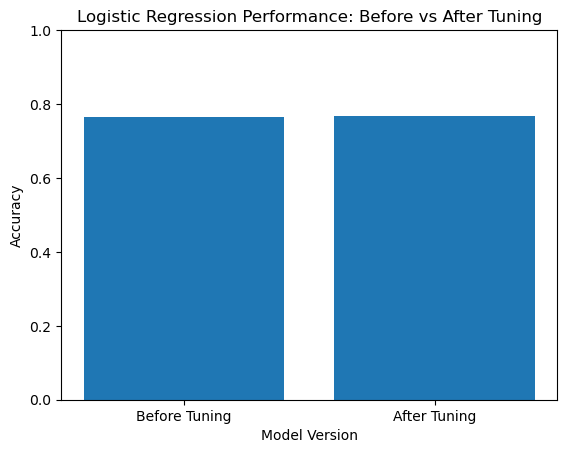

In [51]:
import matplotlib.pyplot as plt

labels = ['Before Tuning', 'After Tuning']
values = [before_acc, after_acc]

plt.figure()
plt.bar(labels, values)
plt.ylim(0, 1)
plt.xlabel("Model Version")
plt.ylabel("Accuracy")
plt.title("Logistic Regression Performance: Before vs After Tuning")
plt.show()

In [53]:
from sklearn.metrics import accuracy_score

before_acc = accuracy_score(y_test, y_pred)        # original logistic
after_acc  = accuracy_score(y_test, tuned_pred)    # tuned logistic

print("Before tuning:", before_acc)
print("After tuning:", after_acc)

Before tuning: 0.7639775216687303
After tuning: 0.7678826554909991


In [55]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# Train baseline model
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

# Evaluate
nb_pred = nb_model.predict(X_test_tfidf)
baseline_acc = accuracy_score(y_test, nb_pred)

print("Baseline Naive Bayes Accuracy:", baseline_acc)
print(classification_report(y_test, nb_pred, target_names=encoder.classes_))

Baseline Naive Bayes Accuracy: 0.7381655395751976
              precision    recall  f1-score   support

    Negative       0.77      0.70      0.73      8374
     Neutral       0.51      0.43      0.47      2509
    Positive       0.76      0.85      0.80     10115

    accuracy                           0.74     20998
   macro avg       0.68      0.66      0.67     20998
weighted avg       0.73      0.74      0.73     20998



In [57]:
from sklearn.model_selection import GridSearchCV

param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]}

grid_nb = GridSearchCV(MultinomialNB(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_nb.fit(X_train_tfidf, y_train)

# Best model
best_nb = grid_nb.best_estimator_
print("Best alpha:", grid_nb.best_params_)

# Evaluate tuned model
nb_tuned_pred = best_nb.predict(X_test_tfidf)
tuned_acc = accuracy_score(y_test, nb_tuned_pred)
print("Tuned Naive Bayes Accuracy:", tuned_acc)
print(classification_report(y_test, nb_tuned_pred, target_names=encoder.classes_))

Best alpha: {'alpha': 1.0}
Tuned Naive Bayes Accuracy: 0.7381655395751976
              precision    recall  f1-score   support

    Negative       0.77      0.70      0.73      8374
     Neutral       0.51      0.43      0.47      2509
    Positive       0.76      0.85      0.80     10115

    accuracy                           0.74     20998
   macro avg       0.68      0.66      0.67     20998
weighted avg       0.73      0.74      0.73     20998



In [59]:
from sklearn.metrics import accuracy_score

# Baseline Naive Bayes predictions
before_acc = accuracy_score(y_test, nb_pred)        # original Naive Bayes

# Tuned Naive Bayes predictions
after_acc  = accuracy_score(y_test, nb_tuned_pred)  # tuned Naive Bayes

print("Before tuning:", before_acc)
print("After tuning:", after_acc)

Before tuning: 0.7381655395751976
After tuning: 0.7381655395751976


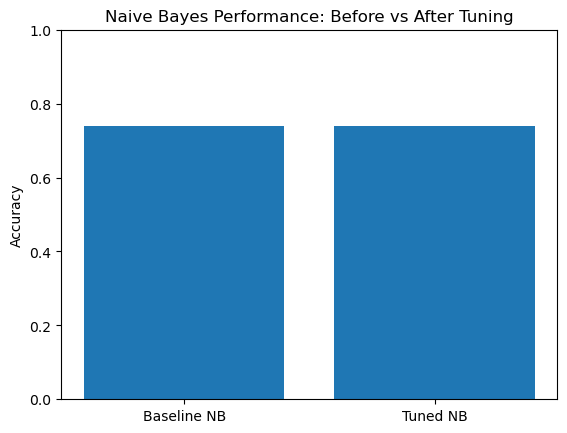

In [61]:
import matplotlib.pyplot as plt

labels = ['Baseline NB', 'Tuned NB']
values = [baseline_acc, tuned_acc]

plt.bar(labels, values)
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Naive Bayes Performance: Before vs After Tuning")
plt.show()

## Increase TF-IDF features

In [64]:
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1,3), stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)

In [66]:
from sklearn.naive_bayes import ComplementNB
cnb_model = ComplementNB()
cnb_model.fit(X_train_tfidf, y_train)

ComplementNB()

In [68]:
from sklearn.metrics import accuracy_score, classification_report

# Predict using ComplementNB
cnb_pred = cnb_model.predict(X_test_tfidf)

# Accuracy
cnb_acc = accuracy_score(y_test, cnb_pred)
print("ComplementNB Accuracy:", cnb_acc)

# Detailed classification report
print(classification_report(y_test, cnb_pred, target_names=encoder.classes_))

ComplementNB Accuracy: 0.7529764739499
              precision    recall  f1-score   support

    Negative       0.78      0.76      0.77      8374
     Neutral       0.46      0.71      0.56      2509
    Positive       0.86      0.75      0.80     10115

    accuracy                           0.75     20998
   macro avg       0.70      0.74      0.71     20998
weighted avg       0.78      0.75      0.76     20998



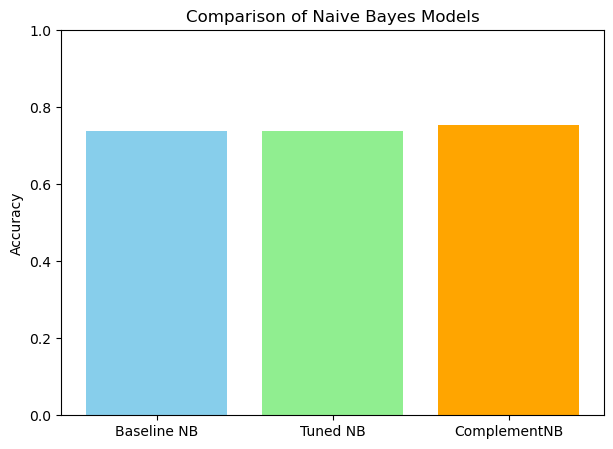

In [70]:
import matplotlib.pyplot as plt

labels = ['Baseline NB', 'Tuned NB', 'ComplementNB']
values = [baseline_acc, tuned_acc, cnb_acc]

plt.figure(figsize=(7,5))
plt.bar(labels, values, color=['skyblue', 'lightgreen', 'orange'])
plt.ylim(0,1)
plt.ylabel("Accuracy")
plt.title("Comparison of Naive Bayes Models")
plt.show()

In [72]:
# Logistic Regression
lr_before_acc = before_acc  # original logistic
lr_after_acc  = after_acc   # tuned logistic

# Naive Bayes
nb_before_acc = baseline_acc  # baseline Multinomial NB
nb_after_acc  = tuned_acc     # tuned Multinomial NB

# ComplementNB
cnb_acc = cnb_acc             # ComplementNB accuracy

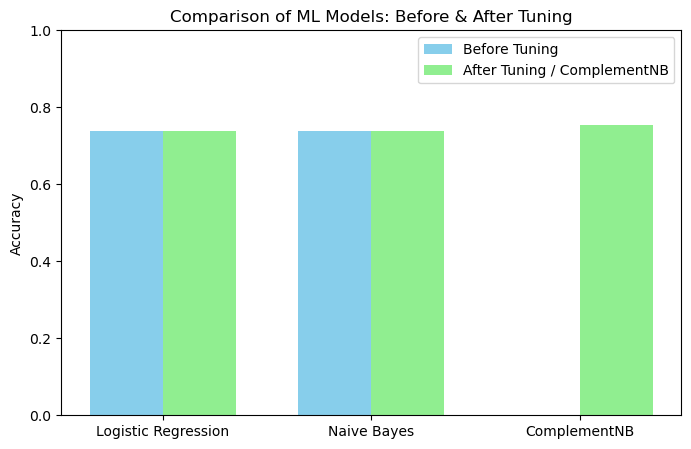

In [74]:
import matplotlib.pyplot as plt
import numpy as np

models = ['Logistic Regression', 'Naive Bayes', 'ComplementNB']
before = [lr_before_acc, nb_before_acc, None]  # ComplementNB has no "before"
after  = [lr_after_acc, nb_after_acc, cnb_acc]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(8,5))
rects1 = ax.bar(x - width/2, [lr_before_acc, nb_before_acc, 0], width, label='Before Tuning', color='skyblue')
rects2 = ax.bar(x + width/2, after, width, label='After Tuning / ComplementNB', color='lightgreen')

ax.set_ylabel('Accuracy')
ax.set_title('Comparison of ML Models: Before & After Tuning')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(0,1)
ax.legend()

plt.show()

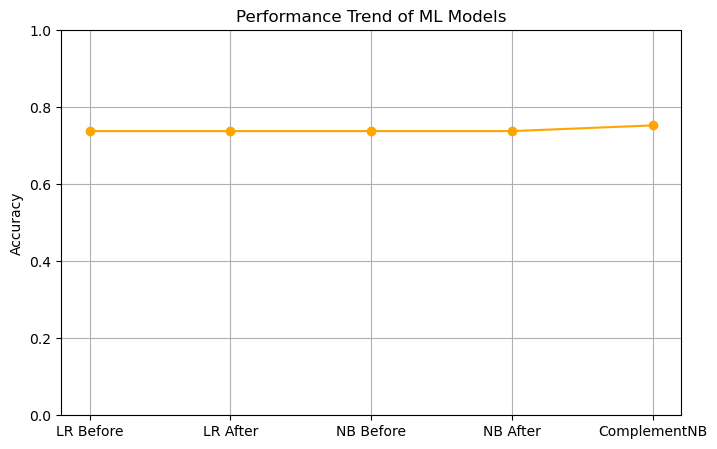

In [76]:
models_line = ['LR Before', 'LR After', 'NB Before', 'NB After', 'ComplementNB']
values_line = [lr_before_acc, lr_after_acc, nb_before_acc, nb_after_acc, cnb_acc]

plt.figure(figsize=(8,5))
plt.plot(models_line, values_line, marker='o', linestyle='-', color='orange')
plt.ylim(0,1)
plt.ylabel('Accuracy')
plt.title('Performance Trend of ML Models')
plt.grid(True)
plt.show()

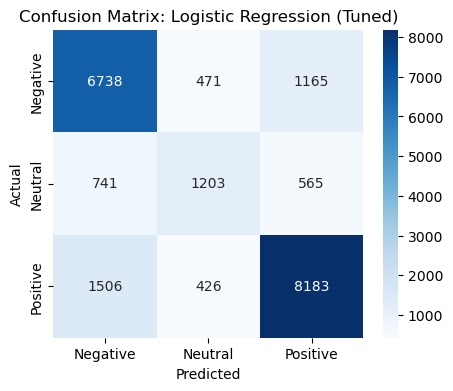

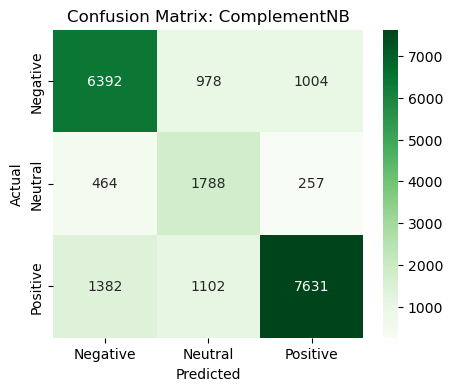

In [78]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Logistic Regression (tuned)
cm_lr = confusion_matrix(y_test, tuned_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm_lr, annot=True, fmt='d', xticklabels=encoder.classes_, yticklabels=encoder.classes_, cmap='Blues')
plt.title('Confusion Matrix: Logistic Regression (Tuned)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# ComplementNB
cm_cnb = confusion_matrix(y_test, cnb_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm_cnb, annot=True, fmt='d', xticklabels=encoder.classes_, yticklabels=encoder.classes_, cmap='Greens')
plt.title('Confusion Matrix: ComplementNB')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()